
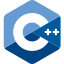
<br>

<div style="text-align:center; font-size:200%;">
  <b>Isolation of Unit Tests</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 09 Isolation of Unit Tests.ipynb -->
<!-- slides/module_410_unit_testing/topic_160_test_isolation.cpp -->


## Unit test

- Tests a small piece of code (a "unit")
- Runs quickly
- *Is isolated*


- A behavior?
  - *Unit of behavior*
  - Part of a scenario/use case/...
  - Original intention of Kent Beck
- A code component?
  - *Unit of code*
  - Often unit = class
  - Widely held view in the literature


## What does "isolated" test mean?

- No interaction between tests?
  - Isolated test cases
  - Classic unit tests (Detroit School, Kent Beck)
- No interaction between the tested unit and the rest of the system?
  - Dependencies are replaced by simple simulations (test doubles)
  - London School


## Isolated test cases (Detroit School)

- Each test case is independent of the others
- Tests can be executed in any order
- Tests can be executed in parallel


### Counterexample: Non-isolated test cases

In [ ]:
#include <iostream>

In [ ]:
void check(bool condition)
{
    if (!condition)
    {
        std::cerr << "Test failed!\n";
    }
}

In [ ]:
#include <chrono>
#include <ctime>
#include <iomanip>
#include <iostream>
#include <thread>

In [ ]:
void print_time(std::string prefix, std::chrono::system_clock::time_point time_point)
{
    std::time_t time = std::chrono::system_clock::to_time_t(time_point);
    std::tm* localTime = std::localtime(&time);
    std::cout << prefix << std::put_time(localTime, "%Y-%m-%d %H:%M:%S") << '\n';
}


## Reasons for non-isolated test cases

- Mutable global state
- Mutable external resources (files, databases, network, ...)


## Isolation of the tested unit

- The tested unit is isolated from all other units
- Test doubles for all dependencies


### Counterexample: Non-isolated unit

- Ticket office that sells tickets for events
- Concrete class `Event` represents an event

In [ ]:
#include <iostream>
#include <stdexcept>
#include <string>

In [ ]:
namespace non_isolated
{
class Event
{
private:
    std::string name{"Unnamed Event"};
    int capacity{};

public:
    Event() = default;
    Event(std::string name, int capacity) : name{name}, capacity{capacity} {}

    std::string get_name() const { return name; }
    int get_capacity() const { return capacity; }
    void purchase(int num_tickets);
};
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
void Event::purchase(int num_tickets)
{
    if (num_tickets > capacity)
    {
        throw std::runtime_error("Not enough capacity");
    }
    capacity -= num_tickets;
}
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
class TicketOffice
{
private:
    std::unordered_map<std::string, Event> events;

public:
    void add_event(Event event) { events[event.get_name()] = event; }
    Event get_event(std::string event_name) { return events[event_name]; }
    bool purchase_tickets(std::string event_name, int num_tickets);
};
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
bool TicketOffice::purchase_tickets(std::string event_name, int num_tickets)
{
    if (events.find(event_name) != events.end())
    {
        try
        {
            events[event_name].purchase(num_tickets);
            return true;
        }
        catch (const std::runtime_error& e)
        {
            std::cerr << "Cannot purchase " << num_tickets << " tickets for "
                      << event_name << '\n';
            std::cerr << e.what() << '\n';
            return false;
        }
    }
    return false;
}
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
void test_purchase_tickets()
{
    TicketOffice ticket_office;
    Event event("CppCon", 100);
    ticket_office.add_event(event);

    bool result = ticket_office.purchase_tickets("CppCon", 10);

    check(result == true);
    check(ticket_office.get_event("CppCon").get_capacity() == 90);
}
} // namespace non_isolated

In [ ]:
namespace isolated
{
class Event
{
public:
    Event() = default;
    Event(const Event&) = delete;
    Event& operator=(const Event&) = delete;
    Event(Event&&) = delete;
    Event& operator=(Event&&) = delete;
    virtual ~Event() = default;

    virtual std::string get_name() const = 0;
    virtual int get_capacity() const = 0;
    virtual void purchase(int num_tickets) = 0;
};
} // namespace isolated

In [ ]:
namespace isolated
{
class ConcreteEvent : public Event
{
private:
    std::string name{"Unnamed Event"};
    int capacity{};

public:
    ConcreteEvent() = default;
    ConcreteEvent(std::string name, int capacity) : name{name}, capacity{capacity} {}

    std::string get_name() const override { return name; }
    int get_capacity() const override { return capacity; }
    void purchase(int num_tickets) override;
};
} // namespace isolated

In [ ]:
namespace isolated
{
void ConcreteEvent::purchase(int num_tickets)
{
    if (num_tickets > capacity)
    {
        throw std::runtime_error("Not enough capacity");
    }
    capacity -= num_tickets;
}
} // namespace isolated

In [ ]:
namespace isolated
{
class TicketOffice
{
private:
    std::unordered_map<std::string, std::unique_ptr<Event>> events;

public:
    void add_event(std::unique_ptr<Event> event)
    {
        events[event->get_name()] = std::move(event);
    }
    Event& get_event(std::string event_name) { return *events.at(event_name); }
    bool purchase_tickets(std::string event_name, int num_tickets);
};
} // namespace isolated

In [ ]:
namespace isolated
{
bool TicketOffice::purchase_tickets(std::string event_name, int num_tickets)
{
    if (events.find(event_name) != events.end())
    {
        try
        {
            events.at(event_name)->purchase(num_tickets);
            return true;
        }
        catch (const std::out_of_range& e)
        {
            std::cerr << event_name << " not found\n";
            std::cerr << e.what() << '\n';
            return false;
        }
        catch (const std::runtime_error& e)
        {
            std::cerr << "Cannot purchase " << num_tickets << " tickets for "
                      << event_name << '\n';
            std::cerr << e.what() << '\n';
            return false;
        }
    }
    return false;
}
} // namespace isolated


### Isolation of `TicketOffice` for tests

- Decouple from all dependencies
- `EventMock` implementation for events

In [ ]:
namespace isolated
{
class EventMock : public Event
{
public:
    std::vector<int> purchase_args{};

    std::string get_name() const override { return "CppCon"; }
    int get_capacity() const override { return 90; }
    void purchase(int num_tickets) override { purchase_args.push_back(num_tickets); }
};
} // namespace isolated

In [ ]:
namespace isolated
{
void test_purchase_tickets()
{
    TicketOffice ticket_office;
    ticket_office.add_event(std::make_unique<EventMock>());

    bool result{ticket_office.purchase_tickets("CppCon", 10)};

    check(result == true);
    check(ticket_office.get_event("CppCon").get_capacity() == 90);
    check(
        static_cast<EventMock&>(ticket_office.get_event("CppCon")).purchase_args ==
        std::vector<int>{10}
    );
}
} // namespace isolated


## Advantages of isolating the tested unit

- Simple structure of the tests
  - Each test belongs to exactly one unit
- Precise identification of errors
- Breaking dependencies/the object graph


## Disadvantages of isolating the tested unit

- Potentially higher effort (e.g. mocks)
- Errors in the interaction between units are not found
- Temptation to write "interaction tests"
- **Risk of coupling to implementation details**


## Recommendation

- Use isolated unit tests (Detroit School)
- Isolate dependencies that "launch a rocket"
  - non-deterministic (e.g. random numbers, current time or date)
  - slow
  - external systems (e.g. database)
- Isolate dependencies that require a complex setup


## Workshop: Virtual University

- In the `code` folder you will find an implementation of a simple management
  system for a university:
- There are courses, professors who teach the courses, students who have to
  work on and submit assignments.
- The code can be found in `code/starter_kits/virtual_university`.
- The `main.cpp` file illustrates how the classes work together and can be
  used.
- (This is not an example of particularly good software architecture, but it
  shows well how the different testing strategies differ.)


- Identify which classes and methods lead to the "most valuable" unit tests.
- Implement these unit tests with Catch2.
  - Ideally, implement tests for all classes that have meaningful tests.
  - If you don't have enough time for that, you can also write tests for only
    part of the code.
  - The `Student` class is a pretty good starting point because it has very
    limited functionality that you can cover with relatively few tests.


- Think about how you would need to rework the system to fully isolate the
  classes in tests, i.e. to test in the London School style.
  - (You don't actually have to implement this because it is quite
    time-consuming, but it is a good exercise to compare the two styles.)